# Hypothesis 6: reviewers with a long history of reviewing have an high % of helpfulness

In [ ]:
#Importing Needed Libraries
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import pearsonr, ttest_ind

In [ ]:
# Connect to MongoDB and select the database
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close()
print(data.shape)

(300639, 11)


In [ ]:
#Preparing Data To Ivestigate The Hypothesis
data['review_date'] = pd.to_datetime(data['review_date'])
data['helpful_upvotes'].fillna(0 , inplace=True)
data['helpful_total'].fillna(0 , inplace=True)
data['helpfulness'] = data['helpful_upvotes']/data['helpful_total']
data['helpfulness'].fillna(0 , inplace=True)
data.head()

,movie,rating,genre,review_date,review_detail,review_id,review_summary,reviewer,spoiler_tag,helpful_upvotes,helpful_total,helpfulness
0,Satisfaction (1988),7,-,2005-08-26,So this is not one of the best movies from the...,rw1158912,Great '80s Comedy!,fechka-1,0,9,13,0.692308
1,Satisfaction (2007– ),6,-,2014-07-05,Satisfaction is an Australian television serie...,rw3044858,What could have been.,MrFrankCastle,0,2,3,0.666667
2,Satomi hakken-den (1983),10,-,2000-06-18,good movie but i suggest watching it and prete...,rw0212472,"1 ninja, 1 samurai, and 6 fighter/adventurers ...",fogish,0,6,8,0.750000
3,Satomi hakken-den (1983),7,-,2012-04-21,"Although based on a classic Japanese novel, Le...",rw2599903,"No, Shinbei... I am your mother.",BA_Harrison,0,5,6,0.833333
4,Satree lek (2000),9,-,2001-04-29,"From Thailand, this film (winner of two 2001 B...",rw0764409,"Against All Odds, a cross between Rocky & ...",GMeleJr,0,8,9,0.888889


In [ ]:
# Group the DataFrame by 'reviewer' and calculate the interval between the first and last review date
reviewer_intervals = data.groupby('reviewer')['review_date'].agg(lambda x: x.max() - x.min()).dt.days

# Create a new DataFrame with reviewer and interval between first and last review
sub_data = pd.DataFrame({'reviewer': reviewer_intervals.index, 'history': reviewer_intervals.values})

print(sub_data)

                   reviewer  history
0                       !@N      208
1                  "Manos!"        0
2       "Runnin"RonnieDobbs        0
3                 $TEVE McD      423
4                   $conan$       29
...                     ...      ...
166472               ~Emil~        0
166473          ~Galvatron~        0
166474                 ~PL~      844
166475            Øystein-3        0
166476                ángel        0

[166477 rows x 2 columns]


In [ ]:
#Calculate The Helpfulness Of Each Reviewer and Merge
mean_scores = data.groupby('reviewer')['helpfulness'].mean().reset_index()
sub_data = sub_data.merge(mean_scores, on='reviewer')

#Calculate The Number Of Reviews Each Reviewer Has and Merge
reviewCount = data.groupby('reviewer')['review_id'].count().reset_index()
sub_data = sub_data.merge(reviewCount, on='reviewer')

sub_data.rename(columns={'review_id': 'count'}, inplace=True)

print(sub_data)

                   reviewer  history  helpfulness  count
0                       !@N      208     0.610294      2
1                  "Manos!"        0     0.500000      1
2       "Runnin"RonnieDobbs        0     1.000000      1
3                 $TEVE McD      423     0.421838      6
4                   $conan$       29     0.000000      2
...                     ...      ...          ...    ...
166472               ~Emil~        0     0.500000      1
166473          ~Galvatron~        0     0.333333      1
166474                 ~PL~      844     0.194050      9
166475            Øystein-3        0     0.500000      1
166476                ángel        0     0.000000      2

[166477 rows x 4 columns]


In [ ]:
#Cleaning Data From 0 Days Reviewing History

sub_data = sub_data[sub_data['history'] != 0]
print(sub_data)

         reviewer  history  helpfulness  count
0             !@N      208     0.610294      2
3       $TEVE McD      423     0.421838      6
4         $conan$       29     0.000000      2
9            *RJ*       20     0.952381      3
13           -628      177     0.712121      4
...           ...      ...          ...    ...
166461      zzz05     3585     0.366667      3
166462   zzzaap-2       58     0.466667      2
166464     zzzorf      603     0.587500      4
166470    ~AleXa~     3739     0.333333      3
166474       ~PL~      844     0.194050      9

[25794 rows x 4 columns]


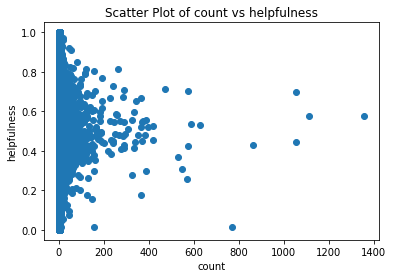

In [ ]:
# Create a scatter plot of 'count' versus 'helpfulness'
plt.scatter(sub_data['count'], sub_data['helpfulness'])


plt.xlabel('count')
plt.ylabel('helpfulness')
plt.title('Scatter Plot of count vs helpfulness')
plt.show()


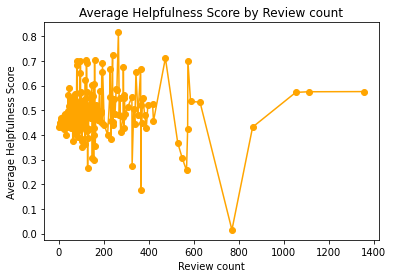

In [ ]:
avg_helpfulness = sub_data.groupby('count')['helpfulness'].mean().reset_index()
avg_helpfulness.sort_values('count', inplace=True)

plt.plot(avg_helpfulness['count'], avg_helpfulness['helpfulness'], marker='o' , color='orange')
plt.xlabel('Review count')
plt.ylabel('Average Helpfulness Score')
plt.title('Average Helpfulness Score by Review count')
plt.show()

In [ ]:
# Calculate the correlation coefficient
correlation_coefficient, p_value = pearsonr(sub_data['count'], sub_data['helpfulness'])
print("Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)

print("average number of reviews iven by individual: ",sub_data['count'].mean())

# Perform a hypothesis test (t-test)
group1 = sub_data['helpfulness'][sub_data['count'] < (sub_data['count'].mean())]
group2 = sub_data['helpfulness'][sub_data['count'] >=  (sub_data['count'].mean())]

t_statistic, p_value2 = ttest_ind(group1, group2)
print("statistic for 2 groups of less /more than average number of reviews")
print("T-statistic:", t_statistic)
print("p-value:", p_value2)

Correlation Coefficient: 0.025734447254172312
p-value: 3.571748081297616e-05
average number of reviews iven by individual:  6.131464681708924
statistic for 2 groups of less /more than average number of reviews
T-statistic: -5.566146599063411
p-value: 2.630224296064598e-08


correlation coefficient close to 0 indicatesa weak or no linear relationship between count and helpfulness.
obtaining small p-value confirms that the observed correlation is statistically significant.

 we can conclude that there is a statistically significant but **very weak** correlation between the 'count' and 'helpfulness' variables based on the small p-value. However, the practical significance or the strength of the relationship is limited due to the small magnitude of the correlation coefficient.

 The t-statistic being negative (-5.5) indicates that the mean of group1 is lower than the mean of group2.
 The p-value being close to 0 indicates that the observed difference between the means of the two groups is unlikely to occur by chance alone.

 t-statistic close to -5.5 and a p-value close to 0 provide evidence for a  difference between the means of the two groups, with group1 having a lower mean than group2 but its not that big of a difference.

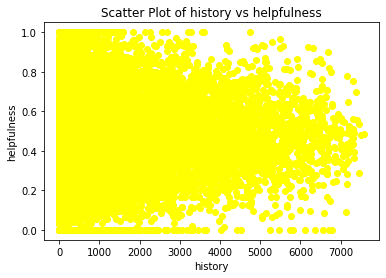

In [ ]:
# Create a scatter plot of 'history' versus 'helpfulness'
plt.scatter(sub_data['history'], sub_data['helpfulness'] ,color='yellow')

plt.xlabel('history')
plt.ylabel('helpfulness')
plt.title('Scatter Plot of history vs helpfulness')
plt.show()

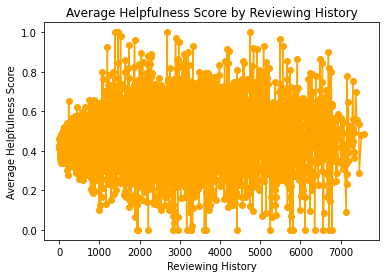

In [ ]:
avg_helpfulness = sub_data.groupby('history')['helpfulness'].mean().reset_index()
avg_helpfulness.sort_values('history', inplace=True)

plt.plot(avg_helpfulness['history'], avg_helpfulness['helpfulness'], marker='o' , color='orange')
plt.xlabel('Reviewing History')
plt.ylabel('Average Helpfulness Score')
plt.title('Average Helpfulness Score by Reviewing History')
plt.show()

In [ ]:
# Calculate the correlation coefficient
correlation_coefficient, p_value = pearsonr(sub_data['history'], sub_data['helpfulness'])
print("Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Perform a hypothesis test (t-test)
group1 = sub_data['helpfulness'][sub_data['history'] <  (sub_data['history'].mean())]  # Select data for a specific duration range
group2 = sub_data['helpfulness'][sub_data['history'] >=  (sub_data['history'].mean())]  # Select data for another duration range

t_statistic, p_value2 = ttest_ind(group1, group2)
print("T-statistic:", t_statistic)
print("p-value2:", p_value2)

Correlation Coefficient: 0.07757420454092936
p-value: 9.965474498842144e-36
T-statistic: -12.95141068699219
p-value2: 3.0362463873627107e-38


A positive correlation coefficient suggests that there is a positive relationship between the variables, meaning that as one vriable increases, the other tends to increase as well.The closer the coefficient is to -1 or 1, the stronger the relationship.

The p-value associated with the correlation coefficient indicates the statistical significance of the relationship.

 so in our case there is statistically significant but very weak correlation between the two as it can also be seen in the scatter plot.

also
A larger absolute t-statistic value suggests a larger difference between the means of the two groups being compared.
And the p-value associated with the t-test indicates the statistical significance of the difference between the groups.
which in our case, results are showing that the two groups are not that different.

